# 4.5 MEV Arbitrage Path Analysis

InIn this notebook, we analyze **MEV arbitrage patterns** without using
decoded swap events. Because our dataset lacks explicit `token_in` and `token_out`, and I don't have enough space for decoding logs here, we cannot directly identify swap pairs.

Instead, we rely on:

- Same-block multi-transaction bundles
- Router call sequences (router paths)
- Repeated patterns of router usage within the same block

Even without explicit `token_in` / `token_out`, these patterns provide
useful signals of MEV-style behavior.


## 1. Imports + Load Data

We load the cleaned ETH transaction table `tx`.


In [20]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

from src.data.load_data import load_clean_transactions

In [21]:
# Load transaction data
tx = load_clean_transactions()
print("Transactions:", len(tx))

tx.head()

Transactions: 13268


,hash,from_address,to_address,block_number,value,block_timestamp
0,0xd8ec648861cf4de73f18f9a034623eeded1b26ec7246...,0xa9264494a92ced04747ac84fc9ca5a0b9549b491,0x835033bd90b943fa0d0f8e5382d9dc568d3fbd96,23772289,4.699994e+19,2025-11-11 00:00:11+00:00
1,0x5843a9e865f9b7222ddb376ea2869c50b389c3a0d858...,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,23772292,5.817089e+19,2025-11-11 00:00:47+00:00
2,0x131571aec26cd23b0134a97341acf9fb0b559b085b68...,0xe50008c1d110da8e56982f46a9188a292ee90a7b,0x1ab4973a48dc892cd9971ece8e01dcc7688f8f23,23772292,3.390013e+18,2025-11-11 00:00:47+00:00
3,0xa1b7caf05dd498111a40ffe269fefb2ae574dde53da0...,0xe40d548eb4fa4d9188fd21723f2fd377456c0876,0x28c6c06298d514db089934071355e5743bf21d60,23772292,7.999922e+18,2025-11-11 00:00:47+00:00
4,0xc1d8e4ffa9e7864d5a38f84aa4532308d411ba35f82e...,0x0eb1665de6473c624dcd087fdeee27418d65ed59,0xa03400e098f4421b34a3a44a1b4e571419517687,23772292,6.318854e+18,2025-11-11 00:00:47+00:00


## 2. Identify Swap Transactions

We restrict attention to **DEX swap transactions** routed via known routers.

> Note:
> - In practice, swap events are often stored in a separate decoded event table  
> - Here we assume swap-related information (tokens in/out) is available or has been preprocessed
>
> You may need to adapt the column names below to match your dataset.

In [22]:
## 2. Identify Router Contracts in the Graph

#### We reuse the **router address list** from 4.2.
router_addresses = {
    "uniswap_v2": [
        "0xf164fc0ec4e93095b804a4795bbe1e041497b92a",
    ],
    "uniswap_v3": [
        "0xe592427a0aece92de3edee1f18e0157c05861564",
    ],
    "1inch": [
        "0x1111111254eeb25477b68fb85ed929f73a960582",
    ],
    "0x_exchange": [
        "0xdef1c0ded9bec7f1a1670819833240f027b25eff",
    ],
    "paraswap": [
        "0xdef171fe48cf0115b1d80b88dc8eab59176fee57",
    ],
    "sushi_swap": [
        "0xd9e1ce17f2641f24ae83637ab66a2cca9c378b9f",
    ],
    "balancer": [
        "0xba12222222228d8ba445958a75a07044adaf5ab",
    ],
    "curve": [
        "0x11111112542d85b3ef69ae05771c22d518637fe",
    ],
    "kyber_swap": [
        "0x1c87257f5e8609940bc751a07bb5c9c3e1b0b76",
    ]
}


router_all = set([a.lower() for lst in router_addresses.values() for a in lst])

tx["to_address_lower"] = tx["to_address"].str.lower()
tx["is_router_tx"] = tx["to_address_lower"].isin(router_all)


In [23]:
tx["to_address_lower"] = tx["to_address"].str.lower()

tx["is_router_tx"] = tx["to_address_lower"].isin(router_all)
tx["router_type"] = None

for router_name, addr_list in router_addresses.items():
    addr_set = set([a.lower() for a in addr_list])
    mask = tx["to_address_lower"].isin(addr_set)
    tx.loc[mask, "router_type"] = router_name



## 3. Same-Block Multi-Transaction Bundles

MEV bots often submit **multiple transactions in the same block**.

We first identify addresses that:

- Send more than one transaction in the same block
- Potentially orchestrate multi-step arbitrage within a single block


In [24]:
# Count tx per (from_address, block_number)
block_counts = (
    tx.groupby(["from_address", "block_number"])["hash"]
      .count()
      .rename("tx_in_block")
)

block_counts.head()


from_address                                block_number
0x00003f0b7045822689ce3a6118846218a2c22cfd  23777805        1
0x0000b8258eb0a75e660317f914294fd2482a453e  23775261        1
                                            23776846        1
                                            23777772        1
0x0000fdf3af21c329851de8e981178928e472edd9  23774835        1
Name: tx_in_block, dtype: int64

In [25]:
# Basic stats on bursts
burst_stats = (
    block_counts.reset_index()
    .groupby("from_address")["tx_in_block"]
    .max()
    .rename("max_tx_in_block")
    .sort_values(ascending=False)
)

print("Top addresses by max_tx_in_block (potential same-block bundles):")
burst_stats.head(10)


Top addresses by max_tx_in_block (potential same-block bundles):


from_address
0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511    16
0x5724ff60178dbda504cda6759ebf54a16146141d    14
0xb028b84783a0381d51dcf0e8ef04b5e502958618     9
0x2fc617e933a52713247ce25730f6695920b3befe     6
0x9c19b0497997fe9e75862688a295168070456951     5
0xa03400e098f4421b34a3a44a1b4e571419517687     4
0x90487897bc505e9619d32279ea1a5e899d18e3ba     4
0x77134cbc06cb00b66f4c7e623d5fdbf6777635ec     4
0x86e284421664840cb65c5b918da59c01ed8fa666     3
0x85c0d1110c57a329ccd6cc91e50fb4666f2287c3     3
Name: max_tx_in_block, dtype: int64

### 3.1 Inspect Example Bundles

We look at a few example (address, block) pairs with multiple tx
to understand the structure of their same-block sequences.


In [26]:
# Select candidate (from_address, block_number) pairs with tx_in_block >= 2
bundle_candidates = (
    block_counts[block_counts >= 2]
    .sort_values(ascending=False)
)

print("Number of (address, block) bundles with >= 2 tx:", len(bundle_candidates))
bundle_candidates.head(10)

Number of (address, block) bundles with >= 2 tx: 199


from_address                                block_number
0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511  23778832        16
0x5724ff60178dbda504cda6759ebf54a16146141d  23773399        14
0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511  23778969        11
                                            23779063        11
                                            23778930        10
                                            23779029        10
0xb028b84783a0381d51dcf0e8ef04b5e502958618  23773380         9
0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511  23778979         8
                                            23779069         8
                                            23778959         7
Name: tx_in_block, dtype: int64

In [29]:
# Function to inspect one bundle
def show_bundle(from_addr, block_num, n=20):
    sub = tx[(tx["from_address"] == from_addr) & (tx["block_number"] == block_num)].copy()
    sub = sub.sort_values("block_timestamp")
    print(f"Bundle for address={from_addr}, block={block_num}, tx_count={len(sub)}")
    display(sub[["hash", "block_number", "block_timestamp", "to_address", "router_type"]].head(n))

# Show a few example bundles
for (addr, bnum), cnt in bundle_candidates.head(3).items():
    show_bundle(addr, bnum)


Bundle for address=0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511, block=23778832, tx_count=16


,hash,block_number,block_timestamp,to_address,router_type
11911,0xf540b4eb2b9ca5c0ec46cb5f32511ad80ed792e913c4...,23778832,2025-11-11 22:00:35+00:00,0x656788f36b535836a86187fb539540c46b9973c5,None
11912,0x833c6073a6a7102d185a8d5c2cc3a91532d8eedfae3d...,23778832,2025-11-11 22:00:35+00:00,0x0d54eec5194747c9cec4cfd0b33c2ea15916578d,None
11913,0xd06bea659e8417ae5ebdec579ebc9eeb7bd2d436d6d0...,23778832,2025-11-11 22:00:35+00:00,0xd958dedb5e7f45c854447ec30915700872e572b0,None
11914,0x8cd1c1ad065abef72d2d2d0fe873509333fc6f4cb49f...,23778832,2025-11-11 22:00:35+00:00,0x00386d30cf0579887ca12b6cadd09acd55ddcdf5,None
11915,0x99dc361ded9c40a8f0707d96b24b3bb95123ade2bf48...,23778832,2025-11-11 22:00:35+00:00,0xc964f192e24b5f571623de300e25d0487c093c54,None
11916,0x424bfb56807b60241ad7539645ce267d80c257607454...,23778832,2025-11-11 22:00:35+00:00,0xc0c66d649e4e91ed51f3d06ddc829b090f663d7e,None
11917,0xd7a0e408b1727bb0f88af8fb9ad2fdd7b1abb21c1535...,23778832,2025-11-11 22:00:35+00:00,0x608285ed47f0ce8b5200356f5b431dfd4611e25c,None
11918,0x4981d8b66008a106572b52c074faddbc4bfefee0d34f...,23778832,2025-11-11 22:00:35+00:00,0x6c749bd67b4256dc78a60da1d3a67b9370f695f9,None
11919,0x0adc9ab8b525f9281bff40f3c3fb949acecac4e4bbb1...,23778832,2025-11-11 22:00:35+00:00,0x0b851342a0bee934bf5c9a90bac9b81ce36b5e48,None
11920,0x6ea1d6b0f31b920302dce497f66adbcac1c18ece99a0...,23778832,2025-11-11 22:00:35+00:00,0x34f363a39823c6eef84c9bd2090e41e6b313e879,None


Bundle for address=0x5724ff60178dbda504cda6759ebf54a16146141d, block=23773399, tx_count=14


,hash,block_number,block_timestamp,to_address,router_type
1898,0xbd9644cabfbb29b72916733d87f95d5645d175002ac2...,23773399,2025-11-11 03:45:11+00:00,0x3f124c700fb5e741f128e28985267d44f56b242f,None
1899,0x16c7aadcabf60f65d9ccf34badf5e2397162d6e4e5a0...,23773399,2025-11-11 03:45:11+00:00,0x3f124c700fb5e741f128e28985267d44f56b242f,None
1900,0xdb8549f7e876ccf9e63d7df32e15c4cdfc138be51d51...,23773399,2025-11-11 03:45:11+00:00,0x3f124c700fb5e741f128e28985267d44f56b242f,None
1901,0xbd6c5d7c965573e7002d65bcdfd8e9eebe3597b07dfa...,23773399,2025-11-11 03:45:11+00:00,0x3f124c700fb5e741f128e28985267d44f56b242f,None
1902,0x6210d984cd0a73c43b33345ebac4cbaa54f4bd68b29d...,23773399,2025-11-11 03:45:11+00:00,0x3f124c700fb5e741f128e28985267d44f56b242f,None
1904,0xd1d3963fd63426a8ccaa53894266095d113d9c94db80...,23773399,2025-11-11 03:45:11+00:00,0x3f124c700fb5e741f128e28985267d44f56b242f,None
1905,0x1106634255de70997c694387f2ca2f42c30879ceea9f...,23773399,2025-11-11 03:45:11+00:00,0x3f124c700fb5e741f128e28985267d44f56b242f,None
1906,0x792107d7c049fc3430b30cf2185b72de5eb83fb3bd37...,23773399,2025-11-11 03:45:11+00:00,0x3f124c700fb5e741f128e28985267d44f56b242f,None
1907,0x0d927858ac61b342c177bc85aa21c26eeef5588234e8...,23773399,2025-11-11 03:45:11+00:00,0x3f124c700fb5e741f128e28985267d44f56b242f,None
1908,0x0102d15639b7c9e7c1686300eb22abc2a434f8b1292e...,23773399,2025-11-11 03:45:11+00:00,0x3f124c700fb5e741f128e28985267d44f56b242f,None


Bundle for address=0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511, block=23778969, tx_count=11


,hash,block_number,block_timestamp,to_address,router_type
12374,0xbf2f204ea1f80e0b05d9a1a08793003e186b9264db27...,23778969,2025-11-11 22:28:11+00:00,0xdb0994410c109c5d4984742ffc7e1636b9c4df9e,None
12375,0x69fbe4ba1ec8869b200e37129a783a11b966a2a506bc...,23778969,2025-11-11 22:28:11+00:00,0x6b48de861e3ad2b3a8d5c370adc8be108f586561,None
12376,0x984b2c73fbd7c4c1275367ca1f5bbceffc4106881e27...,23778969,2025-11-11 22:28:11+00:00,0xd0eaee9d23076925ac8adf12a224e2748f12633b,None
12377,0xbc88c830ece408841a504f6c7e1d60b102db84e78d65...,23778969,2025-11-11 22:28:11+00:00,0x7349d6043e06751f75fd4882344e48bf0d2cb71c,None
12379,0x66bcf071e6ff4eab843307a35122ff1721f6cbfffba1...,23778969,2025-11-11 22:28:11+00:00,0x8b97101ab97c1043ea28665ccbeca5d0a54a33f1,None
12381,0x41f0a3910c668a5bdff4e53446d529c278616e41ad73...,23778969,2025-11-11 22:28:11+00:00,0x1b7b8eba5006fb112c7a2290e4f5b10159190037,None
12383,0x5cf3555928b40cfda5460b72e549f152de3de0b1ecd2...,23778969,2025-11-11 22:28:11+00:00,0xea717cc654c10d7ad57ee7eb610ba2cf46542fe3,None
12384,0x8e1839fbbe3301bca8f799adc0c95dcd0c44e4f15b6c...,23778969,2025-11-11 22:28:11+00:00,0x515d128a859fdec2a7f0bdf231eb666012d342fb,None
12388,0x885725e2fde7a2c3a2108a0c7a727af77ca1fce86472...,23778969,2025-11-11 22:28:11+00:00,0x92a5c24a5b8249a53244d8845f9cc424c7585cf2,None
12390,0x5dec3d6e48e3a6535769a4d549e080a4b4ae717d011c...,23778969,2025-11-11 22:28:11+00:00,0xc0843429da8edc4c4cf598d2ad79411ac96631fc,None


## 4. Router Path Sequences (Same Block)

Even without swap details, we can analyze **router call sequences**.

Within the same block and for the same address:

- We extract the ordered sequence of `router_type` values
- We treat this as a **router path** (e.g., `uniswap_v2 -> 1inch -> uniswap_v3`)
- Then we count how often each router path appears


In [30]:
# Prepare datetime and sorting
tx["datetime"] = pd.to_datetime(tx["block_timestamp"])

tx = tx.sort_values(["from_address", "block_number", "datetime"])


In [31]:
# Define group key: trader + block
tx["group_key"] = tx["from_address"].astype(str) + "_" + tx["block_number"].astype(str)

# For each group, collect ordered router_type sequence
def extract_router_path(df_group):
    """
    Return ordered list of non-null router_type values in this group.
    """
    routers = df_group["router_type"].dropna().tolist()
    # Remove consecutive duplicates
    cleaned = []
    for r in routers:
        if len(cleaned) == 0 or cleaned[-1] != r:
            cleaned.append(r)
    return cleaned if cleaned else None

grouped = tx.groupby("group_key", sort=False)
router_paths = grouped.apply(extract_router_path).rename("router_path")

router_paths.head()


/var/folders/tm/2mpx1bkj39x81n32__pl6vbw0000gn/T/ipykernel_56770/2981433059.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  router_paths = grouped.apply(extract_router_path).rename("router_path")


group_key
0x00003f0b7045822689ce3a6118846218a2c22cfd_23777805    None
0x0000b8258eb0a75e660317f914294fd2482a453e_23775261    None
0x0000b8258eb0a75e660317f914294fd2482a453e_23776846    None
0x0000b8258eb0a75e660317f914294fd2482a453e_23777772    None
0x0000fdf3af21c329851de8e981178928e472edd9_23774835    None
Name: router_path, dtype: object

### 4.1 Frequent Router Paths

We convert router paths to string patterns and count frequencies.

Examples:

- `uniswap_v2`
- `uniswap_v2 -> 1inch`
- `uniswap_v3 -> 0x_exchange -> uniswap_v2`


In [33]:
# Drop groups with no router activity
router_paths_nonempty = router_paths.dropna()

router_path_strings = router_paths_nonempty.apply(lambda p: " -> ".join(p))

path_counts = router_path_strings.value_counts()

print("Number of unique router paths:", len(path_counts))
path_counts.head(20)


Number of unique router paths: 2


router_path
1inch       6
paraswap    1
Name: count, dtype: int64

### 4.2 Path Length Distribution


count    7.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: router_path, dtype: float64


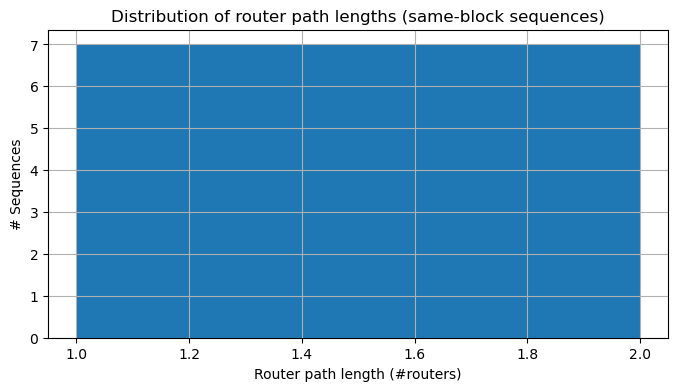

In [34]:
path_lengths = router_paths_nonempty.apply(lambda p: len(p))
print(path_lengths.describe())

plt.figure(figsize=(8, 4))
plt.hist(path_lengths, bins=range(1, path_lengths.max() + 2))
plt.xlabel("Router path length (#routers)")
plt.ylabel("# Sequences")
plt.title("Distribution of router path lengths (same-block sequences)")
plt.show()


## 5. Repeated Router Paths per Address

We now look at which addresses **repeatedly** use the same router paths
across different blocks, which is a strong MEV signature.


In [35]:
# Attach from_address and block_number back to router_paths
router_paths_df = router_paths_nonempty.reset_index()
router_paths_df[["from_address", "block_number"]] = router_paths_df["group_key"].str.split("_", n=1, expand=True)
router_paths_df["block_number"] = router_paths_df["block_number"].astype(int)

router_paths_df.head()


,group_key,router_path,from_address,block_number
0,0x2f28a5e274a99501a3a22888817a4e21507ea2cc_237...,[1inch],0x2f28a5e274a99501a3a22888817a4e21507ea2cc,23778363
1,0x35c31864370bc6f27e6e700c8244553ed218f46e_237...,[1inch],0x35c31864370bc6f27e6e700c8244553ed218f46e,23775788
2,0xad9b9d612eba19ea32965748118b2f29d4f6eddb_237...,[1inch],0xad9b9d612eba19ea32965748118b2f29d4f6eddb,23777960
3,0xc1b0d5fbaaec5bb6d07b83db890eb576e3393e8a_237...,[paraswap],0xc1b0d5fbaaec5bb6d07b83db890eb576e3393e8a,23777063
4,0xce6938e9af4ae3d0324952c31fa06f76f94be949_237...,[1inch],0xce6938e9af4ae3d0324952c31fa06f76f94be949,23772815


In [36]:
# Convert path to string again for grouping
router_paths_df["router_path_str"] = router_paths_df["router_path"].apply(lambda p: " -> ".join(p))

# Count how many times each (address, path) pair appears
addr_path_counts = (
    router_paths_df.groupby(["from_address", "router_path_str"])["block_number"]
                   .nunique()
                   .rename("n_blocks_with_path")
                   .reset_index()
)

addr_path_counts.sort_values("n_blocks_with_path", ascending=False).head(20)


,from_address,router_path_str,n_blocks_with_path
5,0xe20a9ff50b8c3b5baaa17b7f4fdc91169d229989,1inch,2
0,0x2f28a5e274a99501a3a22888817a4e21507ea2cc,1inch,1
1,0x35c31864370bc6f27e6e700c8244553ed218f46e,1inch,1
2,0xad9b9d612eba19ea32965748118b2f29d4f6eddb,1inch,1
3,0xc1b0d5fbaaec5bb6d07b83db890eb576e3393e8a,paraswap,1
4,0xce6938e9af4ae3d0324952c31fa06f76f94be949,1inch,1


### 5.1 Addresses with Highly Repeated Router Paths

These addresses are strong MEV candidates:

- They use routers frequently
- They repeat the **same router pattern** across many blocks


In [37]:
top_addr_paths = (
    addr_path_counts.sort_values("n_blocks_with_path", ascending=False)
                    .head(30)
                    .copy()
)

top_addr_paths.head(10)


,from_address,router_path_str,n_blocks_with_path
5,0xe20a9ff50b8c3b5baaa17b7f4fdc91169d229989,1inch,2
0,0x2f28a5e274a99501a3a22888817a4e21507ea2cc,1inch,1
1,0x35c31864370bc6f27e6e700c8244553ed218f46e,1inch,1
2,0xad9b9d612eba19ea32965748118b2f29d4f6eddb,1inch,1
3,0xc1b0d5fbaaec5bb6d07b83db890eb576e3393e8a,paraswap,1
4,0xce6938e9af4ae3d0324952c31fa06f76f94be949,1inch,1


## 6. Simple Same-Block Arbitrage Signatures

Without swap prices, we cannot compute exact profit.

However, we can still flag **suspicious same-block sequences**:

- More than 2 tx in the same block
- Involving at least one router call
- Similar router paths repeated across blocks


In [38]:
# Reuse bundle_candidates from Section 3
bundle_idx = bundle_candidates.index  # (from_address, block_number)

# Build a DataFrame of bundles with basic flags
bundle_df = pd.DataFrame(list(bundle_idx), columns=["from_address", "block_number"])
bundle_df["tx_in_block"] = bundle_candidates.values

# Check if bundle has any router tx
def has_router_in_bundle(row):
    sub = tx[(tx["from_address"] == row["from_address"]) & (tx["block_number"] == row["block_number"])]
    return sub["is_router_tx"].any()

bundle_df["has_router"] = bundle_df.apply(has_router_in_bundle, axis=1)

bundle_df.head()


,from_address,block_number,tx_in_block,has_router
0,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,23778832,16,False
1,0x5724ff60178dbda504cda6759ebf54a16146141d,23773399,14,False
2,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,23778969,11,False
3,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,23779063,11,False
4,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,23778930,10,False


In [39]:
# Suspicious bundles: multiple tx + at least one router tx
suspicious_bundles = bundle_df[(bundle_df["tx_in_block"] >= 2) & (bundle_df["has_router"])]

print("Number of suspicious same-block bundles:", len(suspicious_bundles))
suspicious_bundles.head(10)


Number of suspicious same-block bundles: 0


,from_address,block_number,tx_in_block,has_router


## 7. Export MEV Path Features (Optional)

We export:

- `path_counts`: global router path frequency  
- `addr_path_counts`: per-address repeated paths  
- `suspicious_bundles`: same-block router bundles  

These features will be used in **4.6 MEV Risk Insights**.


In [ ]:
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save router path frequencies
path_counts.to_csv(os.path.join(OUTPUT_DIR, "mev_router_paths_global.csv"), header=["count"])

# Save per-address router path repetition
addr_path_counts.to_csv(os.path.join(OUTPUT_DIR, "mev_router_paths_per_address.csv"), index=False)

# Save suspicious bundles
suspicious_bundles.to_csv(os.path.join(OUTPUT_DIR, "mev_suspicious_bundles.csv"), index=False)

print("Saved MEV path-related features to:", OUTPUT_DIR)
